***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.1)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While keeping the primary capsule dimension same as original ($P_{capsule} = 8D$). Training with $L_{cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD_2\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_2_5')

FOLDER CREATED =  ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/Mod_2_5


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=7)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=10)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 4

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), 
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 10)          0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 10)          0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
780/781 [============================>.] - ETA: 0s - loss: 0.3062 - prediction_coarse_accuracy: 0.8400 - prediction_medium_accuracy: 0.3882 - prediction_fine_accuracy: 0.2075
  • Coarse Accuracy = 84.00% | Val_Accuracy = 88.60% | LossWeight = 0.16 
  • Medium Accuracy = 38.80% | Val_Accuracy = 49.00% | LossWeight = 0.43 
  • Fine   Accuracy = 20.75% | Val_Accuracy = 31.11% | LossWeight = 0.41 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.31110, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/Mod_2_5\epoch-best.h5
781/781 [==============================] - 50s 54ms/step - loss: 0.3061 - prediction_coarse_accuracy: 0.8400 - prediction_medium_accuracy: 0.3880 - prediction_fine_accuracy: 0.2075 - val_loss: 0.2092 - val_prediction_coarse_accuracy: 0.8860 - val_prediction_medium_accuracy: 0.4900 - val_prediction_fine_accuracy: 0.3111 - lr: 0.0010
Epoch 2/100
780/781 [============================>.] - ETA: 0s - loss: 0.1816 - prediction_coarse_accuracy: 0.

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.0667 - prediction_coarse_accuracy: 0.9712 - prediction_medium_accuracy: 0.9082 - prediction_fine_accuracy: 0.8675
  • Coarse Accuracy = 97.12% | Val_Accuracy = 97.72% | LossWeight = 0.18 
  • Medium Accuracy = 90.82% | Val_Accuracy = 88.87% | LossWeight = 0.40 
  • Fine   Accuracy = 86.75% | Val_Accuracy = 84.61% | LossWeight = 0.43 

Epoch 18: val_prediction_fine_accuracy improved from 0.84060 to 0.84610, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/Mod_2_5\epoch-best.h5
781/781 [==============================] - 87s 112ms/step - loss: 0.0667 - prediction_coarse_accuracy: 0.9712 - prediction_medium_accuracy: 0.9082 - prediction_fine_accuracy: 0.8675 - val_loss: 0.0467 - val_prediction_coarse_accuracy: 0.9772 - val_prediction_medium_accuracy: 0.8887 - val_prediction_fine_accuracy: 0.8461 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0643 - prediction_coarse_a

781/781 [==============================] - 84s 108ms/step - loss: 0.0520 - prediction_coarse_accuracy: 0.9813 - prediction_medium_accuracy: 0.9527 - prediction_fine_accuracy: 0.9370 - val_loss: 0.0398 - val_prediction_coarse_accuracy: 0.9823 - val_prediction_medium_accuracy: 0.9068 - val_prediction_fine_accuracy: 0.8703 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0514 - prediction_coarse_accuracy: 0.9813 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 0.9363
  • Coarse Accuracy = 98.13% | Val_Accuracy = 98.18% | LossWeight = 0.22 
  • Medium Accuracy = 95.21% | Val_Accuracy = 90.62% | LossWeight = 0.39 
  • Fine   Accuracy = 93.63% | Val_Accuracy = 86.73% | LossWeight = 0.39 

Epoch 37: val_prediction_fine_accuracy did not improve from 0.87150
781/781 [==============================] - 83s 106ms/step - loss: 0.0514 - prediction_coarse_accuracy: 0.9813 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 0.9363 

Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0503 - prediction_coarse_accuracy: 0.9826 - prediction_medium_accuracy: 0.9574 - prediction_fine_accuracy: 0.9450
  • Coarse Accuracy = 98.26% | Val_Accuracy = 98.34% | LossWeight = 0.23 
  • Medium Accuracy = 95.74% | Val_Accuracy = 91.36% | LossWeight = 0.39 
  • Fine   Accuracy = 94.50% | Val_Accuracy = 87.55% | LossWeight = 0.38 

Epoch 46: val_prediction_fine_accuracy improved from 0.87450 to 0.87550, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/Mod_2_5\epoch-best.h5
781/781 [==============================] - 72s 93ms/step - loss: 0.0503 - prediction_coarse_accuracy: 0.9826 - prediction_medium_accuracy: 0.9574 - prediction_fine_accuracy: 0.9450 - val_loss: 0.0387 - val_prediction_coarse_accuracy: 0.9834 - val_prediction_medium_accuracy: 0.9136 - val_prediction_fine_accuracy: 0.8755 - lr: 1.5778e-04
Epoch 47/100
781/781 [==============================] - ETA: 0s - loss: 0.0490 - prediction_coarse_ac

781/781 [==============================] - 82s 105ms/step - loss: 0.0482 - prediction_coarse_accuracy: 0.9833 - prediction_medium_accuracy: 0.9601 - prediction_fine_accuracy: 0.9499 - val_loss: 0.0376 - val_prediction_coarse_accuracy: 0.9836 - val_prediction_medium_accuracy: 0.9139 - val_prediction_fine_accuracy: 0.8794 - lr: 9.9440e-05
Epoch 56/100
781/781 [==============================] - ETA: 0s - loss: 0.0482 - prediction_coarse_accuracy: 0.9837 - prediction_medium_accuracy: 0.9615 - prediction_fine_accuracy: 0.9522
  • Coarse Accuracy = 98.37% | Val_Accuracy = 98.40% | LossWeight = 0.24 
  • Medium Accuracy = 96.15% | Val_Accuracy = 91.32% | LossWeight = 0.40 
  • Fine   Accuracy = 95.22% | Val_Accuracy = 87.72% | LossWeight = 0.37 

Epoch 56: val_prediction_fine_accuracy did not improve from 0.87940
781/781 [==============================] - 80s 103ms/step - loss: 0.0482 - prediction_coarse_accuracy: 0.9837 - prediction_medium_accuracy: 0.9615 - prediction_fine_accuracy: 0.9522 

781/781 [==============================] - 62s 79ms/step - loss: 0.0475 - prediction_coarse_accuracy: 0.9839 - prediction_medium_accuracy: 0.9622 - prediction_fine_accuracy: 0.9554 - val_loss: 0.0381 - val_prediction_coarse_accuracy: 0.9846 - val_prediction_medium_accuracy: 0.9148 - val_prediction_fine_accuracy: 0.8783 - lr: 3.7524e-05
Epoch 75/100
781/781 [==============================] - ETA: 0s - loss: 0.0478 - prediction_coarse_accuracy: 0.9842 - prediction_medium_accuracy: 0.9625 - prediction_fine_accuracy: 0.9543
  • Coarse Accuracy = 98.42% | Val_Accuracy = 98.47% | LossWeight = 0.24 
  • Medium Accuracy = 96.25% | Val_Accuracy = 91.34% | LossWeight = 0.40 
  • Fine   Accuracy = 95.43% | Val_Accuracy = 87.92% | LossWeight = 0.36 

Epoch 75: val_prediction_fine_accuracy did not improve from 0.88090
781/781 [==============================] - 47s 60ms/step - loss: 0.0478 - prediction_coarse_accuracy: 0.9842 - prediction_medium_accuracy: 0.9625 - prediction_fine_accuracy: 0.9543 - 

781/781 [==============================] - 66s 85ms/step - loss: 0.0484 - prediction_coarse_accuracy: 0.9836 - prediction_medium_accuracy: 0.9622 - prediction_fine_accuracy: 0.9546 - val_loss: 0.0373 - val_prediction_coarse_accuracy: 0.9843 - val_prediction_medium_accuracy: 0.9147 - val_prediction_fine_accuracy: 0.8798 - lr: 1.4160e-05
Epoch 94/100
781/781 [==============================] - ETA: 0s - loss: 0.0474 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.9550
  • Coarse Accuracy = 98.45% | Val_Accuracy = 98.43% | LossWeight = 0.24 
  • Medium Accuracy = 96.28% | Val_Accuracy = 91.40% | LossWeight = 0.40 
  • Fine   Accuracy = 95.50% | Val_Accuracy = 87.86% | LossWeight = 0.36 

Epoch 94: val_prediction_fine_accuracy did not improve from 0.88090
781/781 [==============================] - 56s 71ms/step - loss: 0.0474 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.9550 - 

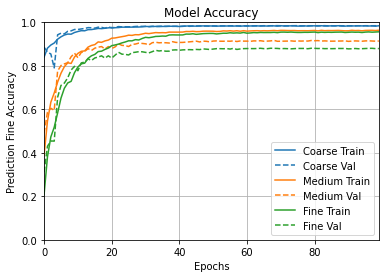

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

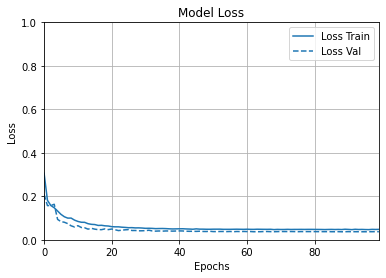

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 10s 22ms/step - loss: 0.0608 - prediction_coarse_loss: 0.0151 - prediction_medium_loss: 0.0627 - prediction_fine_loss: 0.0897 - prediction_coarse_accuracy: 0.9841 - prediction_medium_accuracy: 0.9142 - prediction_fine_accuracy: 0.8796
1. loss ==> 0.06079404428601265
2. prediction_coarse_loss ==> 0.015118010342121124
3. prediction_medium_loss ==> 0.06265289336442947
4. prediction_fine_loss ==> 0.08968321979045868
5. prediction_coarse_accuracy ==> 0.9840999841690063
6. prediction_medium_accuracy ==> 0.9142000079154968
7. prediction_fine_accuracy ==> 0.8795999884605408
313/313 [==============================] - 5s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

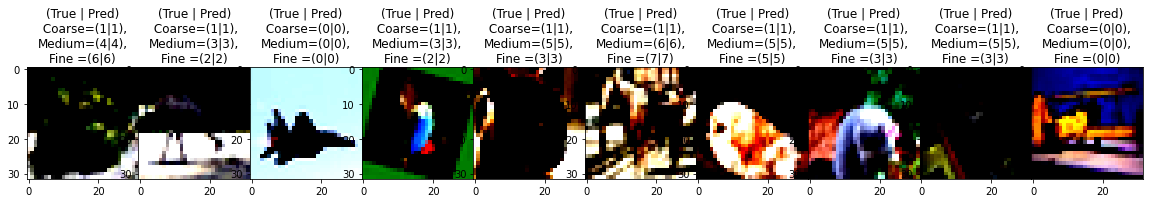

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3933   67]
 [  92 5908]]

  • MEDIUM LEVEL 
[[ 926   20   24   11    3    5   11]
 [  27  938   22    4    1    5    3]
 [  13   12 1968    1    2    3    1]
 [  38    3    4  812   41   64   38]
 [   3    5    4   19  935   29    5]
 [  15    6   14   56   78 1753   78]
 [  14    2    7   43   34   90 1810]]

  • FINE LEVEL 
[[932   7  11   3   4   1   3   5  20  14]
 [  7 949   0   2   0   0   2   0   5  35]
 [ 40   0 819  31  25  26  44  11   4   0]
 [ 14   3  43 741  23  93  59  13   6   5]
 [  6   1  35  27 854  10  33  30   3   1]
 [  5   1  19 124  27 781  21  19   1   2]
 [  3   0  19  24   1   3 940   2   5   3]
 [ 10   0  11  28  15  21   4 906   0   5]
 [ 27   9   5   3   2   2   1   1 940  10]
 [ 11  43   1   2   0   1   0   1   7 934]]

  • Classification Report 


  • COARSE LEVEL 


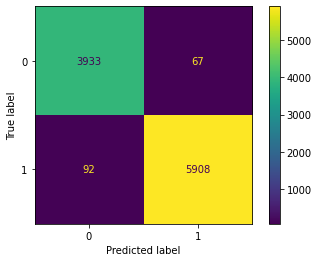

              precision    recall  f1-score   support

           0    0.97714   0.98325   0.98019      4000
           1    0.98879   0.98467   0.98672      6000

    accuracy                        0.98410     10000
   macro avg    0.98296   0.98396   0.98345     10000
weighted avg    0.98413   0.98410   0.98411     10000


  • MEDIUM LEVEL 


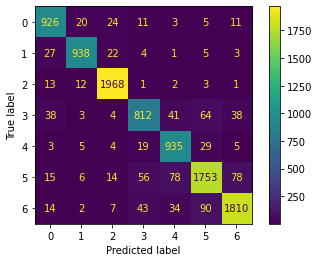

              precision    recall  f1-score   support

           0    0.89382   0.92600   0.90963      1000
           1    0.95132   0.93800   0.94461      1000
           2    0.96329   0.98400   0.97353      2000
           3    0.85835   0.81200   0.83453      1000
           4    0.85466   0.93500   0.89303      1000
           5    0.89944   0.87650   0.88782      2000
           6    0.93011   0.90500   0.91738      2000

    accuracy                        0.91420     10000
   macro avg    0.90728   0.91093   0.90865     10000
weighted avg    0.91438   0.91420   0.91393     10000


  • FINE LEVEL 


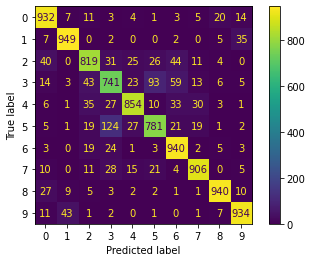

              precision    recall  f1-score   support

           0    0.88341   0.93200   0.90706      1000
           1    0.93682   0.94900   0.94287      1000
           2    0.85047   0.81900   0.83444      1000
           3    0.75228   0.74100   0.74660      1000
           4    0.89800   0.85400   0.87545      1000
           5    0.83262   0.78100   0.80599      1000
           6    0.84914   0.94000   0.89226      1000
           7    0.91700   0.90600   0.91147      1000
           8    0.94854   0.94000   0.94425      1000
           9    0.92567   0.93400   0.92982      1000

    accuracy                        0.87960     10000
   macro avg    0.87940   0.87960   0.87902     10000
weighted avg    0.87940   0.87960   0.87902     10000



In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9255233333333334 
Hierarchical Recall = 0.928 
Hierarchical F1-Score = 0.9265547619047618 
Consistency =  0.9865 
Exact Match =  0.8747
